# INFORME ESTRATÉGICO: OPTIMIZACIÓN DE RENDIMIENTO DE MARKETING - SHOWZ

Este informe presenta un análisis integral del ecosistema de datos de **Showz**, plataforma líder en la comercialización de eventos. A través del estudio de los registros de actividad entre enero de 2017 y diciembre de 2018, este informe busca desglosar la relación entre el comportamiento del usuario, la eficiencia de conversión y la rentabilidad financiera de los canales de adquisición.

> **Nota Técnica sobre Integridad de Datos:** Para garantizar la máxima precisión en el cálculo de métricas de tiempo y economía unitaria, los análisis se basan en activos optimizados en la capa `data/processed`. Se utiliza **Pandas 3.0** con el motor **PyArrow** para asegurar la integridad del tipado y maximizar el rendimiento en operaciones vectorizadas de alta carga.

---

### Objetivos del Análisis
Para orientar la toma de decisiones estratégicas, el análisis se centra en resolver cuatro interrogantes críticas para la escalabilidad del negocio:
* **Patrones de Uso:** ¿Cómo interactúan los usuarios con la plataforma y cuál es su nivel de fidelización?
* **Eficiencia del Embudo:** ¿Cuál es el tiempo promedio hacia la conversión y cómo varía por cohorte?
* **Valor de Vida del Cliente (LTV):** ¿Cuál es el aporte monetario real de cada cliente a largo plazo?
* **Retorno de Inversión (ROMI):** ¿En qué punto y a través de qué canales recuperamos el costo de adquisición (CAC)?

---

### Metodología de Evaluación
El informe se articula en tres dimensiones clave:
1. **Análisis de Producto:** Evaluación del compromiso (*engagement*) y retención mediante métricas de actividad diaria, semanal y mensual.
2. **Economía Unitaria y Ventas:** Estudio de cohortes para determinar el ciclo de vida del cliente y el ticket promedio.
3. **Optimización de Marketing:** Diagnóstico de la inversión publicitaria, cálculo del CAC y determinación de la eficiencia del gasto por fuente de tráfico.

---
---

## Configuración del Entorno y Auditoría de Datos

Para asegurar la transparencia y reproducibilidad del análisis, iniciaré configurando el entorno de ejecución y validando la estructura de los activos optimizados. En esta sección se cargan los datasets de **visitas, pedidos y costos**, permitiendo una inspección inicial de las variables que impulsarán nuestros modelos de decisión.

In [1]:
# Librerías
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Módulo interno
sys.path.append(str(Path.cwd().parent))
from src.data_loader import quick_preview
from src.metrics import (
    get_product_metrics, get_session_metrics, get_retention_matrix,
    get_conversion_time, get_aov_metrics, get_ltv_matrix,
    get_marketing_spend, get_cac_metrics, get_romi_matrix,
)
from src.plotting import (
    plot_cohort_heatmap, plot_time_series, plot_bar, plot_multi_lines,
)

# Configuración del entorno
sns.set_theme(style="whitegrid", palette="muted")
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# Carga de los datasets .parquet
PCSD = Path("../data/processed")

costs  = pd.read_parquet(PCSD / "costs.parquet")
orders = pd.read_parquet(PCSD / "orders.parquet")
visits = pd.read_parquet(PCSD / "visits.parquet")

In [3]:
quick_preview({"visits": visits, "orders": orders, "costs": costs})


─────────────── visits ───────────────  (359,397 filas × 5 columnas)


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740


device                     category
end_ts       timestamp[ns][pyarrow]
source_id            int32[pyarrow]
start_ts     timestamp[ns][pyarrow]
uid                 uint64[pyarrow]

─────────────── orders ───────────────  (50,415 filas × 3 columnas)


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.0,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


buy_ts     timestamp[ns][pyarrow]
revenue           double[pyarrow]
uid               uint64[pyarrow]

─────────────── costs ───────────────  (2,542 filas × 3 columnas)


,source_id,dt,costs
0,1,2017-06-01 00:00:00,75.2
1,1,2017-06-02 00:00:00,62.25


source_id            int32[pyarrow]
dt           timestamp[ns][pyarrow]
costs               double[pyarrow]


---
---

## Fase de Cálculo de Métricas e Informes

Tras validar la calidad de la información, procedemos a la fase de diagnóstico profundo. En esta etapa, transformaremos los registros crudos en indicadores accionables, segmentando el análisis para identificar los motores de crecimiento y los puntos de fricción en el modelo de negocio de Showz.

---

### 1. Análisis de Producto
En esta dimensión inicial, el enfoque se centra en entender la relación orgánica entre el usuario y la interfaz de Showz. Antes de evaluar transacciones financieras, es imperativo diagnosticar si el producto genera el valor suficiente para incentivar la recurrencia o si se comporta como una herramienta de uso estrictamente utilitario.

#### 1.1. Engagement y Fidelización

La salud de una plataforma digital se mide por la recurrencia y el valor que aporta al usuario de forma constante. En esta primera sección, analizaremos el **engagement** para determinar si Showz logra establecerse como una herramienta de uso habitual o si presenta desafíos en la retención de su audiencia.

Evaluaré indicadores clave como:
* **Usuarios Activos (DAU / WAU / MAU):** El pulso del crecimiento y volumen de la audiencia.
* **Sesiones y Duración:** El nivel de profundidad y calidad del uso de la plataforma.
* **Sticky Factor:** La capacidad de la plataforma para retener usuarios activos y convertirlos en visitantes recurrentes (medida de lealtad).
    * **Sticky WAU** ($DAU/WAU$) revela qué tan indispensable es la plataforma en la planificación semanal de eventos.
    * **Sticky MAU** ($DAU/MAU$) refleja la retención sistémica a largo plazo.

In [4]:
metrics = get_product_metrics(visits)
pd.Series(metrics, name="KPI's de Producto")

dau             907.00
wau            3296.00
mau           23228.00
sticky_wau       27.54
sticky_mau        3.91
Name: KPI's de Producto, dtype: float64

##### 1.1.1. Diagnóstico de Engagement: El Desafío de la Retención

Tras el cálculo de los indicadores de actividad, observamos una disparidad significativa entre el volumen de captación y la fidelización real del usuario:

| Métrica | Valor | Interpretación |
| :--- | :--- | :--- |
| **DAU** (Usuarios Diarios) | 907 | Tráfico recurrente base. |
| **WAU** (Usuarios Semanales) | 3,296 | Alcance de planificación a corto plazo. |
| **MAU** (Usuarios Mensuales) | 23,228 | Capacidad de atracción total. |
| **Sticky WAU** | **27.54%** | Frecuencia de uso intensiva en ciclos cortos. |
| **Sticky MAU** | **3.91%** | Retención estructural crítica. |

**Hallazgos Clave**

1. **Perfil de "Visitante Oportunista":** La baja adherencia mensual (3.91%) sugiere que Showz funciona bajo un modelo de **adquisición transaccional**. El usuario accede a la plataforma por una necesidad puntual (un evento específico) y no percibe valor recurrente para regresar una vez satisfecha esa necesidad.
2. **Ciclo de Planificación Semanal:** El Sticky WAU de 27.54% es relativamente saludable para la industria de eventos. Indica que, dentro de la ventana de interés del evento, el usuario consulta la disponibilidad y precios con frecuencia moderada. 
3. **Riesgo Operativo:** Un negocio que depende de un MAU alto con retención baja está obligado a **invertir constantemente en marketing** para reponer los usuarios que se van. La salud financiera a largo plazo depende de elevar el LTV a través de la recurrencia.

> **Hipótesis de Negocio:** La baja retención no es necesariamente un problema de marketing, sino de **frecuencia de oferta** o falta de incentivos (loyalty programs) que motiven al usuario a explorar la cartelera más allá de su búsqueda inicial.

---

#### 1.2. Dinámica de Sesiones: Calidad del Engagement

Para confirmar si el tráfico de Showz es meramente transaccional, analizamos la intensidad del uso a través de la duración de las sesiones y la frecuencia de visitas por usuario. Una plataforma con alta fidelización suele presentar sesiones recurrentes y tiempos de navegación que permitan la exploración del catálogo.

In [5]:
session_stats = get_session_metrics(visits)
pd.Series(session_stats, name="Análisis de Sesiones")

asl_mean             643.04
asl_median           300.00
asl_mode              60.00
sessions_per_user      1.58
Name: Análisis de Sesiones, dtype: float64

##### 1.2.1. Diagnóstico de la Experiencia de Usuario (Sesiones)

El análisis de la distribución del tiempo de permanencia revela una asimetría crítica que define la relación del usuario con la plataforma:

| Indicador | Valor | Interpretación de Negocio |
| :--- | :--- | :--- |
| **ASL (Promedio)** | 643.04 s | Sesgado por una minoría de sesiones de larga duración. |
| **ASL (Mediana)** | 300.00 s | El "punto de equilibrio": el 50% de las sesiones duran menos de 5 min. |
| **ASL (Moda)** | **60.00 s** | **Comportamiento típico:** La mayoría de los usuarios resuelve su intención en 1 min. |
| **Sesiones por Usuario** | 1.58 | Nivel de recurrencia bajo; predomina la visita de "única ocasión". |

**Hallazgos Estratégicos**

1. **Eficiencia vs. Exploración:** La moda de **60 segundos** confirma que el usuario utiliza Showz como una herramienta de consulta rápida. No existe un proceso de exploración de catálogo o "descubrimiento" de eventos. El usuario entra, busca un dato específico (o compra si ya está decidido) y sale.
2. **Anomalía en el Promedio (Outliers):** La diferencia de más de **500** segundos entre la **moda** y el **promedio** indica la presencia de usuarios con sesiones inusualmente largas. Estos podrían ser usuarios que dejan la pestaña abierta o, en el mejor de los casos, usuarios con una alta intención de compra que comparan múltiples opciones. Sin embargo, no representan el estándar del negocio.
3. **El desafío del "One-and-Done":** Una frecuencia de **1.58 sesiones por usuario** en un periodo de dos años es alarmante para la sostenibilidad financiera. Confirma que Showz atrae a una audiencia de paso. El costo de adquisición de marketing se está diluyendo en una sola interacción, lo que pone una presión inmensa sobre la tasa de conversión inicial.

> **Conclusión de Producto:** La plataforma es funcionalmente eficiente (el usuario encuentra lo que busca rápido), pero emocionalmente débil (no retiene ni genera curiosidad). Para mejorar el LTV, es imperativo implementar estrategias de *cross-selling* que aumenten la profundidad de la sesión.

---

#### 1.3. Análisis de Retención por Cohortes

La prueba de fuego para cualquier producto digital es su capacidad de retener a los usuarios adquiridos. A continuación, segmentamos a los usuarios según su mes de primera visita y observamos qué porcentaje regresa en los meses subsiguientes.

Este análisis permite identificar si existen mejoras en la retención a lo largo del tiempo o si el producto sufre de una obsolescencia prematura.

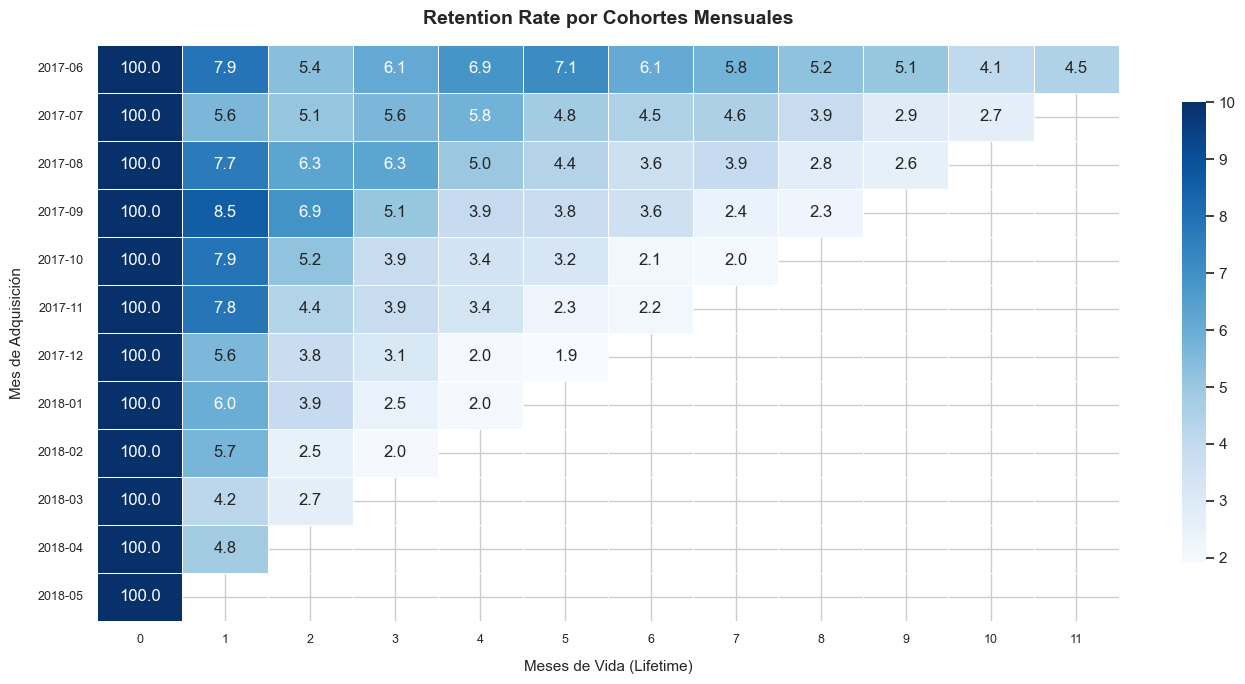

In [6]:
retention = get_retention_matrix(visits)

# Visualización de la matriz de retención
title_ret = ('Retention Rate por Cohortes Mensuales')
x_ret     = ('Meses de Vida (Lifetime)')
y_ret     = ('Mes de Adquisición')
plot_cohort_heatmap(retention, title_ret, x_ret, y_ret, fmt=".1f", vmax=10, figsize=(14, 7))

##### 1.3.1. Diagnóstico del Análisis de Retención

La visualización de las cohortes mensuales confirma un comportamiento de **"utilidad transaccional"** extremo. El ratio de retención refuerza la hipótesis de un interés puntual en el producto (entradas) y nulo en la plataforma como destino recurrente.

| Métrica | Observación | Implicación de Negocio |
| :--- | :--- | :--- |
| **Retención Mes 1** | **4.8% - 7.9%** | Red Flag: Pérdida masiva del capital de adquisición casi inmediata. |
| **Efecto Acantilado** | Caída del 100% al ~6% | El modelo de Showz es un "cubo perforado" que depende enteramente de captación nueva. |
| **Estabilidad de Cohortes** | Tendencia plana tras el Mes 1 | No hay estacionalidad ni mejoras en el producto que hayan movido la aguja de retención. |

**Interpretación Estratégica:**
Es intrínseco al mercado de *ticketing* enfrentar frecuencias bajas; sin embargo, cifras por debajo del 10% en el primer mes indican que Showz no está logrando capitalizar el *interés remanente*. Si un usuario compra una entrada para un concierto hoy, Showz no logra que regrese el próximo mes a buscar teatro, deportes u otros eventos.

> **Veredicto de Producto:** Estamos ante un servicio de "búsqueda y captura". La rentabilidad no vendrá de la recurrencia (fidelización), sino de maximizar el margen en la **única transacción** que el usuario realiza o de reducir drásticamente el costo de captación.

---
---

### 2. Análisis de Ventas y Economías Unitarias

En esta dimensión, dejamos de observar el comportamiento de navegación para centrarnos en la efectividad comercial. Analizaremos cómo y cuánto dinero generan los usuarios para determinar si el modelo de negocio es escalable.

---

#### 2.1 El Ciclo de Conversión (Time to Purchase)

Antes de hablar de montos, debemos saber cuánto tarda un usuario en comprar. ¿Compran el mismo día que entran o necesitan varias visitas?

En esta sección medimos la velocidad del embudo de ventas. Un ciclo de conversión corto indica una alta intención de compra y una interfaz eficiente, mientras que un ciclo largo sugiere que el usuario necesita múltiples puntos de contacto o comparaciones de precio antes de decidirse.

In [7]:
days_to_purchase = get_conversion_time(visits, orders)
conversion_stats = {
    'Media (días)': days_to_purchase.mean(),
    'Mediana (días)': days_to_purchase.median(),
    '(73%)': days_to_purchase.quantile(0.73),
    'Q3 (75%)': days_to_purchase.quantile(0.75),
    'Moda (días)': days_to_purchase.mode()[0],
    'Mínimo (días)': days_to_purchase.min(),
    'Máximo (días)': days_to_purchase.max(),
}
print(pd.Series(conversion_stats, name="Ciclo de Conversión"))
print(days_to_purchase.value_counts().head())

Media (días)       16.729869
Mediana (días)      0.000000
(73%)               1.000000
Q3 (75%)            2.000000
Moda (días)         0.000000
Mínimo (días)       0.000000
Máximo (días)     363.000000
Name: Ciclo de Conversión, dtype: float64
time_to_conversion
0    26363
1     1011
2      563
3      434
4      324
Name: count, dtype: int64[pyarrow]


##### 2.1.1. Diagnóstico del Ciclo de Conversión (Time to Purchase)

El análisis del tiempo transcurrido entre el primer contacto y la transacción final revela un **embudo de ventas de alta velocidad**, donde la ventana de oportunidad para capturar al cliente es extremadamente estrecha.

| Métrica | Valor | Interpretación Técnica |
| :--- | :---: | :--- |
| **Moda** | 0 días | La gran mayoría de las compras ocurre en el primer contacto. |
| **Mediana** | 0 días | El 50% de los clientes convierte de forma instantánea. |
| **Percentil 73 ($P_{73}$)** | 1 día | Casi el 75% de la base compra en menos de 24 horas. |
| **Media ($\mu$)** | 16.73 días | Sesgada por valores atípicos (compras tardías). |
| **Máximo** | 363 días | Casos aislados de conversión tras un año de contacto inicial. |

**Hallazgos Estratégicos**
* **Predominancia de la Compra por Impulso/Necesidad:** El hecho de que la Moda y la Mediana sean 0 confirma que **Showz** es un destino de "baja consideración". El usuario no entra a "investigar" o comparar durante días; entra cuando necesita el boleto y lo compra en esa misma sesión.
* **El Espejismo del Promedio:** Los 16.7 días de promedio son engañosos. Menos del 25% de los usuarios tarda más de 2 días en comprar. Confiar en la media para planificar campañas de *retargeting* sería un error costoso, ya que la mayoría de la audiencia ya decidió su compra (o se fue) en el Día 0.
* **Riesgo de Abandono (Churn):** Si el usuario no compra en los primeros 3 días, la probabilidad de conversión cae drásticamente. Los usuarios que tardan meses en comprar representan un costo de mantenimiento de datos y marketing que difícilmente se recupera, indicando una posible falta de confianza inicial o indecisión en eventos de largo plazo.

> **Veredicto de Ventas:** El éxito de **Showz** depende de la **fricción cero**. Dado que el 70%+ de las ventas son inmediatas, cualquier error en la pasarela de pago o lentitud en la carga durante la primera visita resulta en una pérdida definitiva de la venta.

---

#### 2.2. Tamaño de los Pedidos (Ticket Promedio - AOV)

En esta sección analizamos el **Average Order Value (AOV)** para determinar la escala de las transacciones individuales. 

Entender el ticket promedio nos permite identificar si **Showz** opera bajo un modelo de volumen (muchas transacciones de bajo valor) o un modelo de valor (transacciones premium), lo cual es fundamental para definir el presupuesto de adquisición.

$$AOV = \frac{Total\ Revenue}{Total\ Orders}$$

Ticket Promedio de Pedidos Pagados: $ 5.00


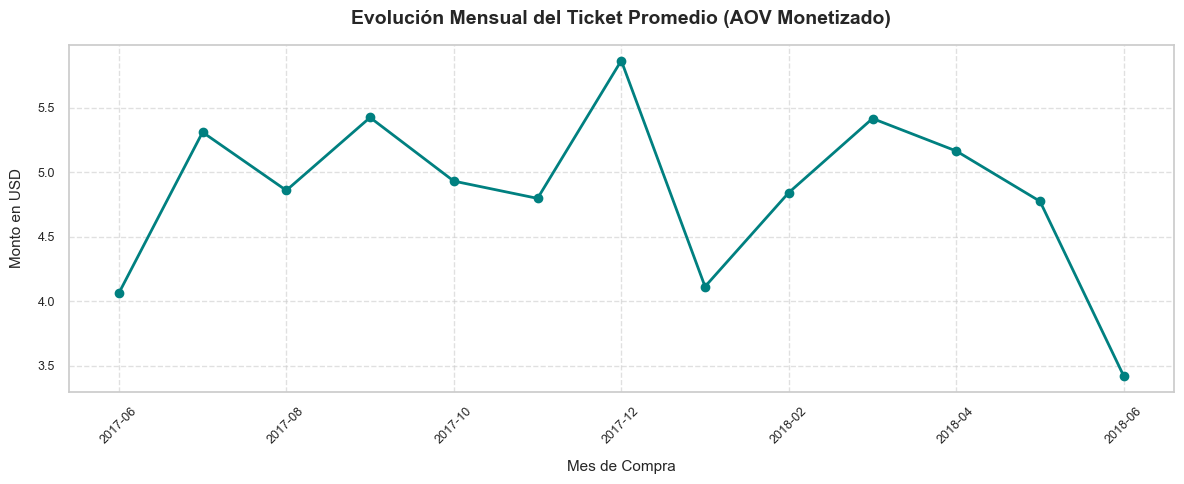

In [8]:
aov_results = get_aov_metrics(orders)
print(f"Ticket Promedio de Pedidos Pagados: $ {aov_results['aov_paying']:.2f}")

# Convertimos el índice de Period a String para Matplotlib
aov_results['monthly_aov'].index = aov_results['monthly_aov'].index.astype(str)

plot_time_series(
    data=aov_results['monthly_aov'],
    title="Evolución Mensual del Ticket Promedio (AOV Monetizado)",
    xlabel="Mes de Compra",
    ylabel="Monto en USD",
)

##### 2.2.1. Diagnóstico del Ticket Promedio (AOV Monetizado)

Al aislar las transacciones con valor, observamos que el ingreso por pedido es **modesto** y presenta una **alta sensibilidad estacional**, lo que dificulta significativamente la estabilidad del flujo de caja.

| Métrica | Valor | Observación Estratégica |
| :--- | :---: | :--- |
| **AOV Monetizado General** | ~$5.00 | Ticket de entrada bajo; modelo basado en volumen masivo. |
| **Pico Máximo (Dic 2017)** | $5.80 | Correlación positiva con eventos de fin de año. |
| **Mínimo Histórico (Jun 2018)** | ~$3.40 | Desplome crítico que marca el fin del periodo analizado. |


**Análisis de la Volatilidad Temporal**

1.  **Ciclo de Cierre de Año (2017):** Se observa una tendencia alcista saludable desde junio (**$4.00**) hasta diciembre (**$5.80**), sugiriendo una cartelera de eventos más robusta o de mayor valor percibido durante el cierre de año.
2.  **El "Efecto Enero":** La caída drástica de diciembre 2017 a enero 2018 (volviendo a niveles de **$4.00**) indica una fuerte dependencia de la estacionalidad festiva. El usuario de **Showz** parece tener un "agotamiento de gasto" inmediato al iniciar el año.
3.  **Recuperación y Colapso en 2018:** A pesar de un repunte alentador hacia marzo (**$5.40**), el desplome hacia junio de 2018 es alarmante. Sin datos comparativos de 2017, no podemos confirmar si es un patrón cíclico o una pérdida de competitividad.

**Hallazgos Estratégicos**

* **Paradoja Vacacional:** Resulta contraintuitivo que los periodos de vacaciones de 2018 muestren una contracción en el ticket promedio. Esto podría indicar que Showz carece de oferta para eventos **"premium"** de verano o que su catálogo se limita a eventos de bajo costo.
* **Margen de Maniobra Estrecho:** Con un AOV de **$5.00**, hay muy poco espacio para absorber el **CAC** (Costo de Adquisición). 

> [!CAUTION] **Riesgo Operativo:** Si el costo de atraer a un usuario es superior a un par de dólares, el negocio podría estar operando en **pérdidas unitarias** debido a la baja retención.

---

#### 2.3. Valor de Vida del Cliente (LTV Acumulado)

Esta es la **métrica reina**. Utilizaremos el análisis de **cohortes** para observar cómo evoluciona el ingreso por usuario a medida que pasa el tiempo en la plataforma.

* **Objetivo:** Calcular el LTV acumulado por mes de vida de la cohorte.
* **Rentabilidad:** Este dato es fundamental para compararlo con el **CAC (Costo de Adquisición)**; si el $LTV > CAC$, el modelo de negocio es escalable.

$$LTV_{n} = \frac{\sum_{i=0}^{n} Revenue_{i}}{Initial\ Cohort\ Size}$$

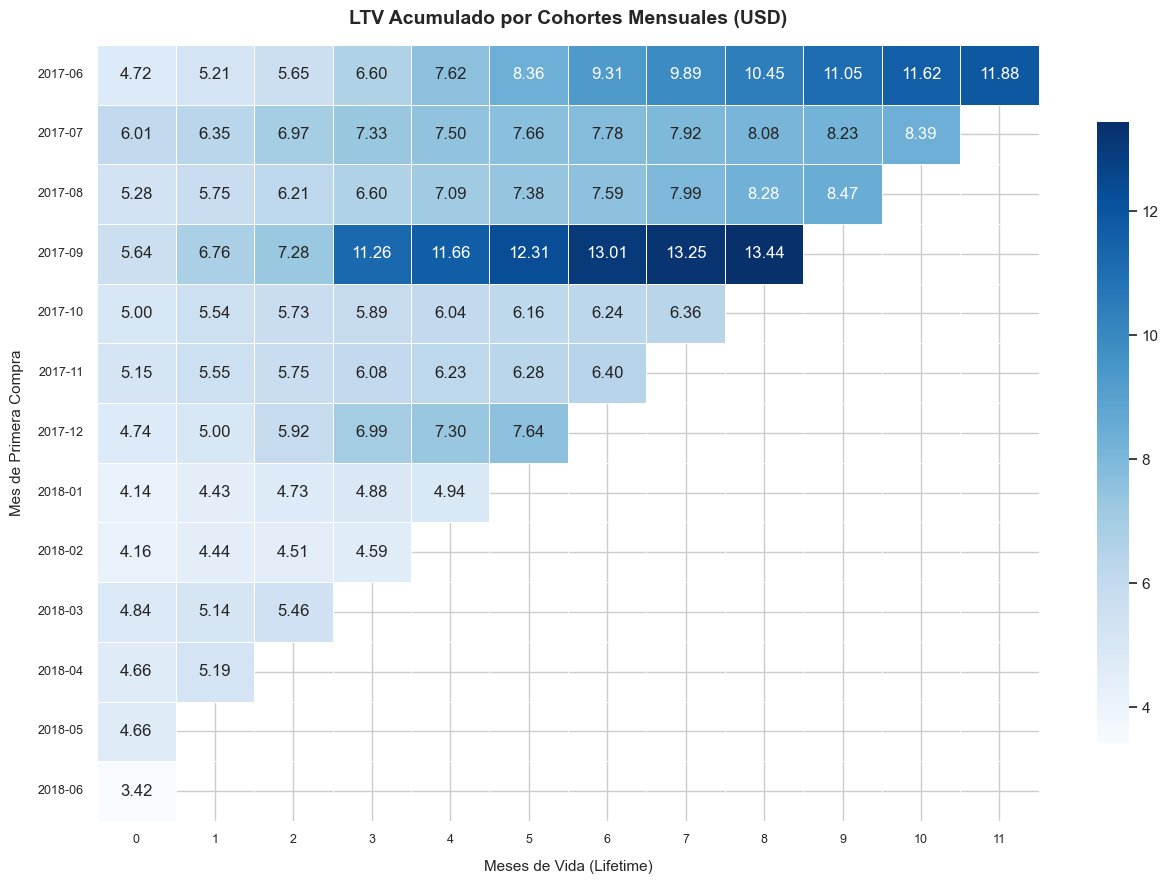

In [9]:
ltv_matrix = get_ltv_matrix(orders)
plot_cohort_heatmap(
    data=ltv_matrix.astype('float64'), 
    title='LTV Acumulado por Cohortes Mensuales (USD)', 
    xlabel='Meses de Vida (Lifetime)', 
    ylabel='Mes de Primera Compra', 
    fmt=".2f", 
    vmax=None, 
    figsize=(13, 9)
)

##### 2.3.1 Diagnóstico del Valor de Vida (LTV Acumulado)

El análisis de cohortes monetarias revela un **techo de ingresos por usuario muy bajo**, lo que condiciona toda la estrategia de marketing a una eficiencia extrema en el costo de adquisición ($CAC$).

| Cohorte Clave | LTV Mes 0 | LTV Final | Crecimiento Total | Observación |
| :--- | :---: | :---: | :---: | :--- |
| **2017-06** | $4.72 | $11.88 | +$7.16 | Crecimiento constante (~$0.40 - $1/mes). |
| **2017-09** | $5.64 | $13.44 | +$7.80 | **Mejor cohorte:** Salto masivo en el Mes 3 ($11.26). |
| **2017-12** | $4.74 | $7.64 | +$2.90 | Excepción positiva en un periodo de baja retención. |
| **2018-01 a 2018-06** | ~$4.40 | ~$5.00 | < $1.00 | **Estancamiento casi total** tras el primer mes. |

**Hallazgos Estratégicos**

* **El "Techo" de las Cohortes Recientes:** Desde octubre de 2017, la mayoría de las cohortes apenas logran sumar un dólar extra a su valor inicial a lo largo de su vida. Esto sugiere que el inventario o la relevancia de la plataforma ha disminuido para los nuevos usuarios.
* **Anomalía de Septiembre 2017:** Esta cohorte es atípica; el salto a **$11.26** en su tercer mes de vida indica una recompra masiva, posiblemente ligada a un evento estacional de gran envergadura que no se repitió con la misma fuerza en meses posteriores.
* **Riesgo de Unit Economics:** Con un $LTV$ promedio que oscila entre los **$4 y $6** para las cohortes más recientes, operar bajo pérdidas para ganar cuota de mercado sería una estrategia suicida. No hay suficiente "recorrido" en el gasto del usuario para recuperar un $CAC$ agresivo.
* **Inconsistencia del Usuario:** La baja retención observada anteriormente se traduce aquí en una curva de $LTV$ casi plana. **Showz** no tiene clientes "fieles", tiene "compradores de una vez" que no justifican una inversión alta en programas de lealtad.

> **Veredicto Financiero:** La supervivencia de **Showz** depende de un $CAC$ extremadamente bajo. Incluso nuestra mejor cohorte ($13.44) apenas deja margen si consideramos gastos operativos y de plataforma. Estamos ante un modelo que **solo es rentable si la captación es orgánica** o de muy bajo costo por clic.

---
---

### 3. Análisis de Marketing

Tras entender que Showz opera con una retención baja y un ticket promedio de aproximadamente $5.00, la viabilidad del negocio depende enteramente de la eficiencia en la captación. En esta sección, auditamos la inversión publicitaria para determinar qué canales son rentables y cuáles están destruyendo valor.

Evaluaremos:
* **Inversión por Canales:** Distribución del presupuesto y detección de anomalías en el gasto.
* **Costo de Adquisición de Clientes (CAC):** El precio real de "comprar" un nuevo cliente por cada fuente.
* **ROMI (Return on Marketing Investment):** El análisis final de rentabilidad cruzando el LTV vs. el CAC.

---

#### 3.1 Inversión por Canales

El primer paso es entender la estrategia de distribución de capital. Un negocio saludable no solo diversifica sus fuentes, sino que optimiza el gasto hacia aquellas que muestran escalabilidad. Analizamos el gasto total y su evolución mensual por `source_id`.

Total gastado en marketing en el periodo analizado: 329,131.62 USD


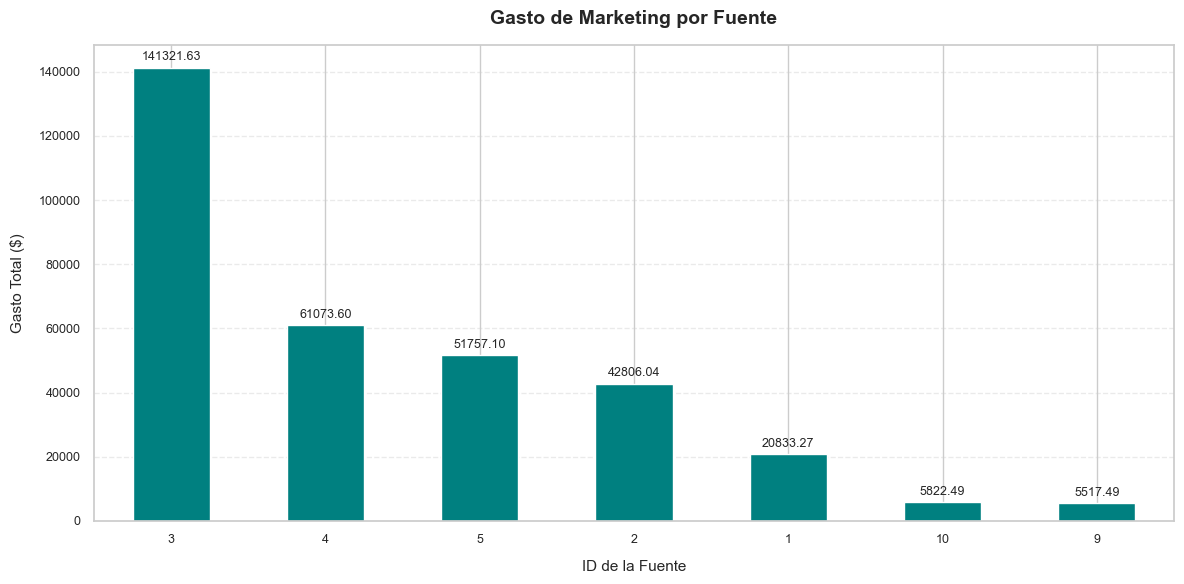

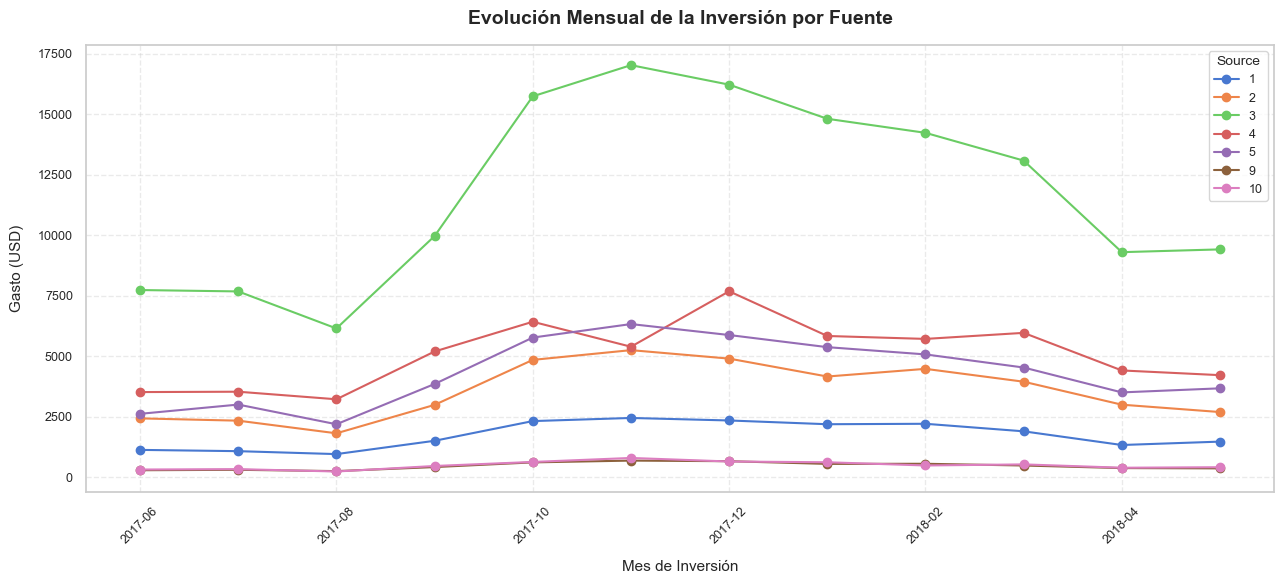

In [10]:
spend = get_marketing_spend(costs)
print(f"Total gastado en marketing en el periodo analizado: {spend['spend_by_source'].sum():,} USD")

plot_bar(
    data=spend['spend_by_source'],
    title="Gasto de Marketing por Fuente",
    xlabel="ID de la Fuente",
    ylabel="Gasto Total ($)",
    annotate=True
)

spend['spend_over_time'].index = spend['spend_over_time'].index.astype(str)

plot_multi_lines(
    data=spend['spend_over_time'],
    title="Evolución Mensual de la Inversión por Fuente",
    xlabel="Mes de Inversión",
    ylabel="Gasto (USD)"
)

##### 3.1.1. Diagnóstico de Distribución de Capital

La inversión total acumulada en el periodo analizado asciende a **$329,131.62 USD**. Al desglosar este monto por fuente, identificamos una concentración de recursos que define la dependencia operativa de la plataforma:

| Fuente (Source ID) | Inversión Total | % del Presupuesto | Comportamiento Mensual |
| :--- | :--- | :---: | :--- |
| **Fuente 3** | ~$140,000 | 42.5% | Dominante, con picos de hasta ~$17,500/mes. |
| **Fuentes 4, 5 y 2** | $40k - $60k | ~45% (Combinado) | Seguimiento constante de la tendencia general. |
| **Fuente 1** | ~$20,000 | ~6% | Canal de soporte secundario. |
| **Fuentes 9 y 10** | ~$5,000 | < 2% | Canales marginales o experimentales. |

**Hallazgos Estratégicos**

* **Riesgo de Concentración:** La **Fuente 3** recibe casi la mitad del presupuesto total. Sin un análisis de atribución profundo que justifique esta disparidad, **Showz** presenta una dependencia crítica hacia este canal, lo que la hace vulnerable a cambios en los algoritmos o costos por clic ($CPC$) de dicha plataforma.
* **Correlación Temporal Homogénea:** El análisis multilínea revela que todas las fuentes siguen el mismo patrón de oscilación. Esto indica que el departamento de marketing no está rotando el presupuesto buscando eficiencia, sino que está reaccionando a la estacionalidad del mercado de forma uniforme.
* **Patrones de Impulso:** Al cruzar estas curvas con la evolución del ticket promedio ($AOV$), se identifican picos de inversión que coinciden con los periodos de mayor gasto del usuario, validando que el marketing captura la demanda en momentos clave, aunque a un costo potencialmente alto.

> [!TIP] El hecho de que todas las fuentes compartan la misma evolución sugiere que **Showz** ha identificado un "canal ganador" (Fuente 3) y lo está explotando. Sin embargo, el verdadero desafío es la rentabilidad: si el $CAC$ de la Fuente 3 es superior al $LTV$ promedio, esa inversión de $140,000 no es crecimiento, es una hemorragia de capital.

---

#### 3.2 Costo de Adquisición de Clientes (CAC)

El CAC nos indica cuántos dólares de inversión publicitaria se requieren para generar un único cliente pagador. Para que Showz sea sostenible, el CAC debe ser significativamente menor al LTV acumulado que calculamos en la sección anterior (~$11.88 en las mejores cohortes).

$$CAC = \frac{\text{Gasto en Marketing}}{\text{Número de Nuevos Clientes}}$$

CAC promedio global: $7.96 USD


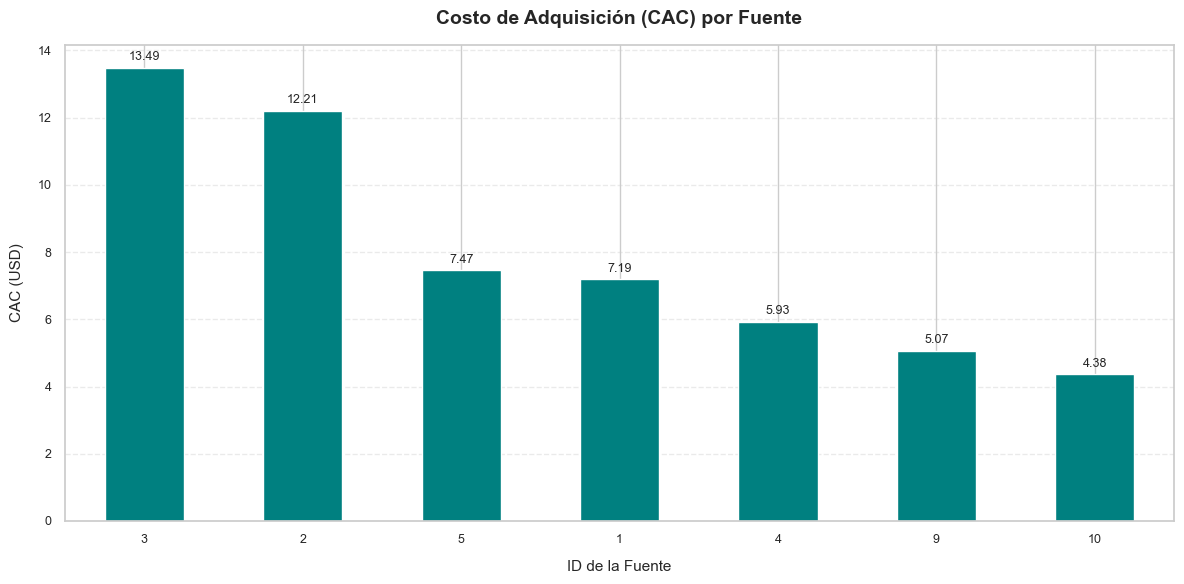

In [11]:
cac = get_cac_metrics(visits, orders, costs)

print(f"CAC promedio global: ${cac['cac_by_source'].mean():.2f} USD")

plot_bar(
    data=cac['cac_by_source'].sort_values(ascending=False),
    title="Costo de Adquisición (CAC) por Fuente",
    xlabel="ID de la Fuente",
    ylabel="CAC (USD)",
    annotate=True,
)

##### 3.2.1. Diagnóstico de Eficiencia de Adquisición ($CAC$)

El análisis del costo por cliente revela una gestión de presupuesto ineficiente en el proyecto **Showz**. Con un **$CAC$ Global de 7.96 USD**, la empresa gasta en promedio un **59% más** de lo que recupera en la primera transacción ($5.00 AOV$), lo que genera una presión insostenible sobre la retención.

| Fuente (Source ID) | $CAC$ Unitario | Relación vs. $LTV$ Máximo ($11.88) | Estatus de Rentabilidad |
| :--- | :---: | :---: | :--- |
| **Fuente 3** | $13.49 | Déficit de -$1.61 | 🔴 **Crítico** |
| **Fuente 2** | $12.21 | Déficit de -$0.33 | 🟠 **Ineficiente** |
| **Fuente 5** | $7.47 | Margen de +$4.41 | 🟡 **Moderado** |
| **Fuente 1** | $7.19 | Margen de +$4.69 | 🟡 **Moderado** |
| **Fuente 4** | $5.93 | Margen de +$5.95 | 🟢 **Saludable** |
| **Fuente 9** | $5.07 | Margen de +$6.81 | 🟢 **Saludable** |
| **Fuente 10** | $4.38 | Margen de +$7.50 | 💎 **Óptimo** |

**Hallazgos Estratégicos**

* **La Trampa de la Fuente 3:** Es el canal donde más se invierte (~$140,000) y, paradójicamente, es el más caro. Un **$CAC$ de $13.49** es superior al valor de vida máximo registrado ($11.88), lo que implica que cada cliente adquirido por esta vía representa una **pérdida neta**, independientemente de su permanencia.
* **Ineficiencia Crítica en Fuente 2:** A pesar de recibir el 13% del presupuesto, su $CAC$ de **$12.21** la sitúa fuera de los parámetros de rentabilidad operativa, captando menos usuarios y a un costo mayor que los canales secundarios.
* **Oportunidades de Escalabilidad (4, 9 y 10):** Estos canales muestran una eficiencia notable. Especialmente la **Fuente 10**, con un $CAC$ de **$4.38**, es la única que permite rentabilidad desde la primera compra. El hecho de que tengan presupuestos marginales (~$5,000) sugiere una falta de optimización: se invierte poco en lo que funciona y mucho en lo que pierde dinero.

> [!CAUTION] **Showz** está "comprando" crecimiento a un precio que no puede pagar. La estrategia actual de marketing es regresiva: se está inyectando capital masivo en los canales que más dinero destruyen (3 y 2), mientras se ignoran las fuentes que realmente podrían sostener la economía unitaria del negocio (10 y 9).

---

#### 3.3. Rentabilidad y Retorno de Inversión (ROMI)

La prueba definitiva de la salud financiera de Showz es el **ROMI**. Esta métrica nos dice cuántos meses tarda una cohorte en "pagar" su propio costo de adquisición. Si el ROMI es menor al 100% (o 1.0), la cohorte aún no ha recuperado la inversión inicial de marketing.

$$ROMI = \frac{LTV}{CAC}$$

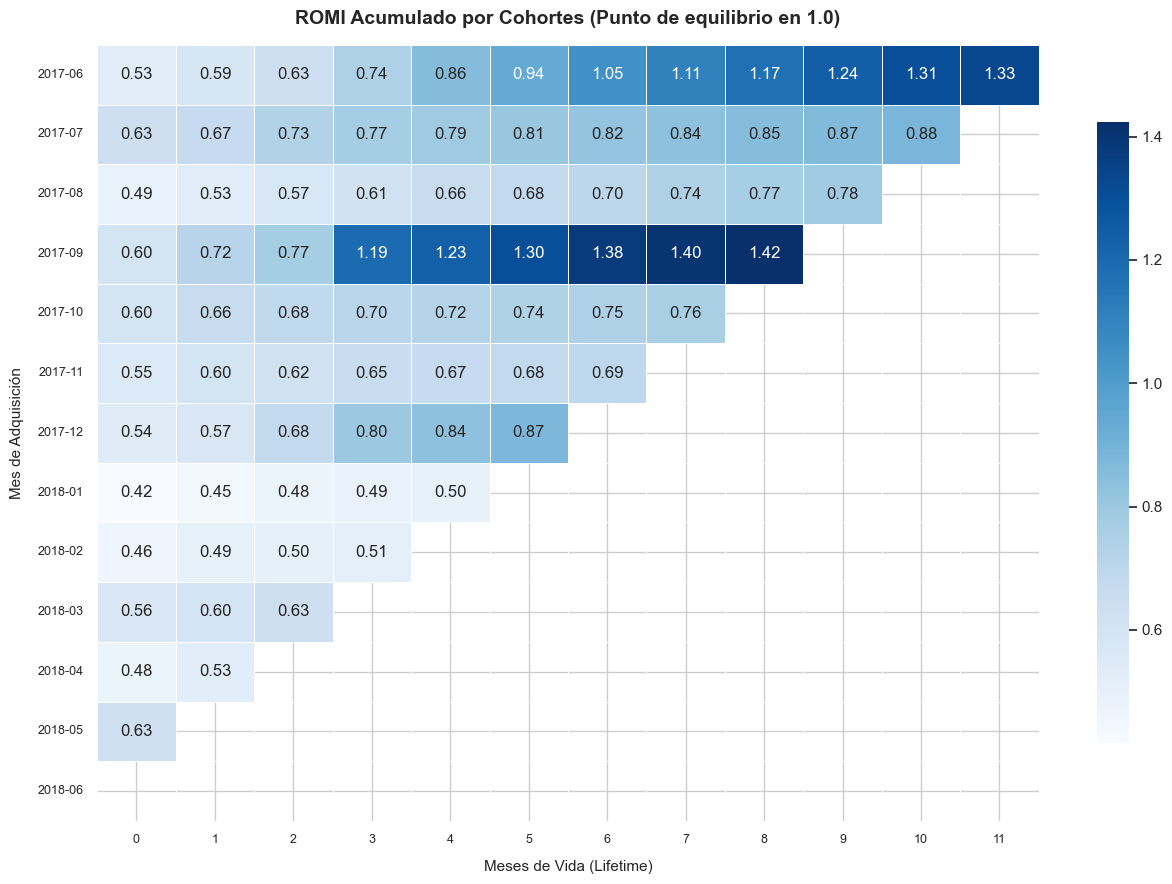

In [12]:
romi = get_romi_matrix(orders, costs)

plot_cohort_heatmap(
    data=romi,
    title="ROMI Acumulado por Cohortes (Punto de equilibrio en 1.0)",
    xlabel="Meses de Vida (Lifetime)",
    ylabel="Mes de Adquisición",
    fmt=".2f",
    figsize=(13, 9),
)

##### 3.3.1. Diagnóstico de Rentabilidad ($ROMI$ Acumulado)

El **$ROMI$ (Return on Marketing Investment)** es el indicador definitivo de la salud financiera del proyecto. Un valor de **1.0** representa el punto de equilibrio (*Breakeven*); cualquier cifra inferior indica que la cohorte aún opera bajo pérdidas.

| Cohorte de Adquisición | Mes de Breakeven | $ROMI$ Final | Estatus |
| :--- | :---: | :---: | :--- |
| **2017-06** | Mes 6 | 1.33 | 🟢 **Rentable** |
| **2017-07 a 2017-08** | Nunca | < 0.88 | 🟡 **En pérdida** |
| **2017-09** | Mes 3 | 1.42 | 💎 **Máxima Eficiencia** |
| **2017-10 a 2017-12** | Nunca | < 0.87 | 🟡 **En pérdida** |
| **2018-01 a 2018-05** | Nunca | < 0.65 | 🔴 **Crítico** |

**Hallazgos Estratégicos**

* **Sostenibilidad Selectiva:** Solo las cohortes de junio y septiembre de 2017 lograron superar el umbral de rentabilidad. La cohorte de septiembre fue la más eficiente, alcanzando el punto de equilibrio en apenas 3 meses gracias a una combinación de $LTV$ alto ($13.44$) y un $CAC$ moderado.
* **La Degradación de 2018:** Todas las cohortes adquiridas en 2018 presentan un desempeño alarmante, sin lograr recuperar siquiera el 55% de la inversión inicial. Esto coincide con el desplome del ticket promedio ($AOV$) observado hacia junio de 2018 ($3.40$).
* **Matemática de la Inviabilidad:** El $CAC$ de la **Fuente 3** ($13.49$) es superior incluso al $LTV$ más alto registrado en la historia de la plataforma ($13.44$). Esto significa que es estadísticamente imposible que la inversión en el canal principal retorne un solo centavo de ganancia bajo las condiciones actuales.


> [!IMPORTANT]
>
> **Showz** está operando un modelo de crecimiento deficitario. La empresa inyecta el **42.5%** de su presupuesto en una fuente (**Source 3**) con un costo de adquisición superior al valor de vida del cliente. 
>
> **Recomendación inmediata:** Pausar la inversión en las fuentes **3** y **2** para redistribuirla hacia los canales **10, 9 y 4**, los únicos con un $CAC$ que permite alcanzar el *breakeven* en el corto plazo.

---
---

## **ESTRATEGIA DE OPTIMIZACIÓN DE RENTABILIDAD: INFORME FINAL "SHOWZ"**

---

**1. RESUMEN EJECUTIVO**

Tras auditar el ciclo de vida del cliente y la eficiencia del gasto publicitario entre 2017 y 2018 para el proyecto de **Showz**, se identifica una crisis de **Economía Unitaria**. El modelo actual es insostenible: el costo promedio de adquisición ($CAC$) de **7.96 USD** supera sistemáticamente el ingreso generado por el usuario en su primera compra ($AOV$) de **5.00 USD**.

La plataforma captura demanda de forma eficiente (conversión en Día 0), pero falla críticamente en la retención, perdiendo al **95%** de los usuarios tras el primer mes. La supervivencia financiera depende de una reasignación agresiva del presupuesto hacia canales eficientes y la evolución del producto hacia la recurrencia.

---

**2. KEY INSIGHTS**

**A. Fragilidad del Modelo de Producto**
* **Visitantes Oportunistas:** El *Sticky MAU* de **3.91%** confirma que el usuario no percibe a **Showz** como un destino habitual, sino como una herramienta transaccional de un solo uso.
* **Eficiencia vs. Emoción:** El *ASL* (duración media de sesión) mediano de **5 minutos** y la moda de **1 minuto** demuestran una plataforma funcionalmente rápida, pero incapaz de fomentar una segunda compra.

**B. Desbalance Financiero ($LTV$ vs. $CAC$)**
* **Techo de Ingresos:** El $LTV$ promedio en las cohortes de 2018 se ha estancado entre **4.40 y 5.00 USD**, dejando un margen nulo para absorber costos operativos.
* **La Hemorragia de la Fuente 3:** Este canal absorbe el **42.5%** de la inversión total con un $CAC$ de **13.49 USD**, cifra que supera incluso el valor de vida máximo histórico (**13.44 USD**), destruyendo valor neto con cada nuevo cliente.

**C. Ventanas de Oportunidad**
* **Alta Intención de Compra:** El **73%** de los clientes convierte en menos de 24 horas.
* **Canales Joya:** Las fuentes **10, 9 y 4** presentan costos de adquisición saludables (**< 6.00 USD**), permitiendo alcanzar el punto de equilibrio mucho antes que los canales masivos.

---

**3. RECOMENDACIONES ESTRATÉGICAS**

**I. Reingeniería del Presupuesto de Marketing (Inmediato)**
* **Desinversión en Canales Deficitarios:** Reducir drásticamente la inversión en las **Fuentes 3 y 2**. El $CAC$ de la Fuente 3 (**13.49 USD**) supera incluso el $LTV$ de las mejores cohortes históricas (**11.88–13.44 USD**), y las cohortes recientes de 2018 apenas recuperan entre el **33% y 37%** de ese costo de adquisición ($LTV$ de **4.40–5.00 USD**).
* **Escalabilidad de Canales Eficientes:** Redistribuir el **50%** del presupuesto liberado hacia las Fuentes **1, 4, 5, 9 y 10**.

**II. Optimización de la Conversión y Ticket Promedio**
* **Estrategia de Upselling en el "Día 0":** Implementar sugerencias de eventos relacionados o servicios adicionales en el *checkout* para elevar el $AOV$ por encima de los **5.00 USD** actuales.
* **Fricción Cero:** Mantener la eficiencia de carga y pagos, ya que el **73%** de las conversiones ocurre en menos de 24 horas, concentrando la rentabilidad en la experiencia de la primera visita.

**III. Pivotaje hacia la Retención (Mediano Plazo)**
* **Programas de Reactivación:** Implementar campañas de *retargeting* y *email marketing* post-compra para elevar la tasa de sesiones por usuario de **1.58** a niveles más competitivos.

---

**4. PRÓXIMOS PASOS**

1.  **Dashboard de Control:** Configurar un monitor de $CAC$ vs. $LTV$ por canal con alertas automáticas cuando el $ROMI$ proyectado baje de **1.0**.
2.  **Análisis de Atribución:** Investigar si la **Fuente 3** actúa como canal de asistencia antes de eliminarla por completo.
3.  **Encuestas de Voice of Customer (VoC):** Entender por qué el **95%** de los usuarios no regresa para identificar fricciones en el catálogo.


> **VERDICTO FINAL:** El éxito de **Showz** no vendrá de gastar más, sino de gastar mejor. La transición de un marketing de volumen a uno de **eficiencia unitaria** es la única vía para asegurar la escalabilidad de la plataforma.

---
---